In [1]:
! head -n 6 README.md

# Enhanced dataset with counter-examples for `BERT : aa_seq -> prot_abundance`

Used quantities from all Ho et al. (2018) experiments, not just medians,
by having protein sequences repeated.
For each sequence duplicate, have a shuffled version with abundance zero.
Dataset prepared with the notebook `prep_data.ipynb`


In [2]:
import inspect
import json
import os
import sys
from pathlib import Path
import yaml

import numpy as np
from scipy import stats
import scipy.special as special
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import torch
from tape import ProteinBertForValuePrediction, TAPETokenizer

import seaborn as sns
import matplotlib.pyplot as plt

from scripts.general import preprocess, plotting


%load_ext autoreload 
%autoreload 2


plt.rcParams['font.size'] = 14

In [3]:
from scipy.stats import normaltest, pearsonr, spearmanr
from scipy.special import inv_boxcox
from scipy.spatial.distance import jensenshannon
from sklearn import metrics
from sklearn.metrics import r2_score

from scripts.general import analysis, data

from IPython.display import display, Math, Latex

In [4]:
import random

RND_SEED = 42

torch.manual_seed(RND_SEED)
np.random.seed(RND_SEED)
random.seed(RND_SEED)
torch.backends.cudnn.benchmark = False

if torch.cuda.device_count() > 0:
    torch.cuda.manual_seed_all(RND_SEED)

model_dir = Path('../../model/bert')
bert_checkpoint_fname = model_dir / 'learn_abundance_transformer_parallel_22-01-14-10-36-57_027418'
    
model = ProteinBertForValuePrediction.from_pretrained(bert_checkpoint_fname, output_attentions=True)
model.eval()
tokenizer = TAPETokenizer(vocab='iupac')

In [5]:
! cat data/config.yaml

data_root: '~/projects/DeepTranslation'
protein_sequence: 'results/20211223_182228/data/augmented_sequences_with_counterexamples.fasta'
protein_abundance: 'results/20211223_182228/data/augmented_abundance_with_counterexamples.csv'
input: 'seq'
target: 'Median_molecules_per_cell'
merge_col: 'swissprot_ac'


In [6]:
with Path('data/config.yaml').open('r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

data_root = os.path.expanduser(config['data_root'])
fasta_fname = Path(data_root) / config['protein_sequence']
abundances_fname = Path(data_root) / config['protein_abundance']
median_abundances = pd.read_csv('../../data/ho2018/prot_abundance_molecules_per_cell_no_gfp.csv')

In [7]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                            Param #
ProteinBertForValuePrediction                                     --
├─ProteinBertModel: 1-1                                           --
│    └─ProteinBertEmbeddings: 2-1                                 --
│    │    └─Embedding: 3-1                                        30,720
│    │    └─Embedding: 3-2                                        1,048,576
│    │    └─Embedding: 3-3                                        2,048
│    │    └─LayerNorm: 3-4                                        2,048
│    │    └─Dropout: 3-5                                          --
│    └─ProteinBertEncoder: 2-2                                    --
│    │    └─ModuleList: 3-6                                       83,984,384
│    └─ProteinBertPooler: 2-3                                     --
│    │    └─Linear: 3-7                                           1,049,600
│    │    └─Tanh: 3-8                                             

### Discard counter-examples when mesuring performance

Otherwise results in two classes: examples and counters (bimodal distribution)

In [8]:
BOXCOX_LAMBDA = -0.05155

all_sequences = preprocess.fasta_to_seq_df(fasta_fname)
abundances = pd.read_csv(abundances_fname)

seq_and_abundances = pd.merge(all_sequences, abundances, on='swissprot_ac')[
    ['swissprot_ac', 'seq', 'Median_molecules_per_cell']
]
seq_and_abundances = seq_and_abundances.query('Median_molecules_per_cell > 1e-5')
abundances = seq_and_abundances['Median_molecules_per_cell'].values
abundances = stats.boxcox(seq_and_abundances['Median_molecules_per_cell'].values,
                          lmbda=BOXCOX_LAMBDA)
sequences = seq_and_abundances['seq'].values


# Recreate splitting from training
random_seed = 42
(sequences_train, sequences_test,
 abundances_train, abundances_test) = data.split_on_unique_inputs(sequences, abundances,
                                                                   test_size=0.2,
                                                                   shuffle=True,
                                                                   random_state=random_seed)
(sequences_valid, sequences_test,
 abundances_valid, abundances_test) = data.split_on_unique_inputs(sequences_test, abundances_test,
                                                                   test_size=0.5,
                                                                   shuffle=True,
                                                                   random_state=random_seed)

set(sequences_test).intersection(set(sequences_train))

set()

### Predict on medians

In [9]:
seq_and_median_abundanes_test = pd.merge(
    pd.merge(
        pd.Series(sequences_test, name='seq').drop_duplicates(),
        all_sequences,
        on='seq'
    ),
    median_abundances[['swissprot_ac', 'Median_molecules_per_cell']],
    on='swissprot_ac'
).query(
    'seq not in @sequences_train'
)

In [10]:
seq_and_median_abundanes_test.shape

(436, 3)

In [11]:
seq_and_median_abundanes_test['Median_molecules_per_cell'] = stats.boxcox(
    seq_and_median_abundanes_test['Median_molecules_per_cell'].values, 
    lmbda=BOXCOX_LAMBDA
)

In [12]:
# seq_and_median_abundanes_test.to_csv('model_test_set.csv', index=False)

In [13]:
predictions_test = []
for seq in tqdm(seq_and_median_abundanes_test['seq'].values):
    tokenized_seq = torch.tensor([tokenizer.encode(seq)])
    pred, _ = model(tokenized_seq)
    predictions_test.append(pred.detach().numpy()[0][0])
    
predictions_test = np.array(predictions_test)

  0%|                                                                                                                                           | 0/436 [00:00<?, ?it/s]/tmp/ipykernel_6985/3051455714.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640811925055/work/torch/csrc/utils/tensor_new.cpp:201.)
  tokenized_seq = torch.tensor([tokenizer.encode(seq)])
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 436/436 [08:46<00:00,  1.21s/it]


In [14]:
abundances_test = seq_and_median_abundanes_test['Median_molecules_per_cell'].values

analysis.model_performance_table(abundances_test, predictions_test)

,measure,value
0,MSE,0.256865
1,MAE,0.399687
2,MASE,0.685330
3,JSD,0.000761
4,Pearson,0.745741
5,Spearman,0.703019
6,R^2,0.555443


Text(0.5, 1.0, 'Test set')

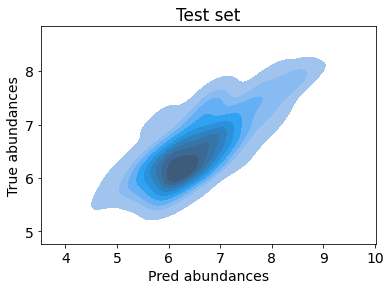

In [15]:
sns.kdeplot(x=abundances_test, y=predictions_test, fill=True)
# sns.scatterplot(x=abundances_test, y=predictions_test, color='k', alpha=0.7)

plt.xlabel('Pred abundances')
plt.ylabel('True abundances')
plt.title('Test set')

In [ ]:
model_test_predictions = seq_and_median_abundanes_test.copy()

model_test_predictions = model_test_predictions.assign(
    predictions_test = predictions_test
)

model_test_predictions.to_csv('model_test_predictions.csv.gz', compression='gzip', index=False)

### Reporting figure

In [16]:
from sklearn.linear_model import LinearRegression

the_true_values = np.log10(special.inv_boxcox(abundances_test, BOXCOX_LAMBDA)).reshape(-1, 1)
the_predicted_values = np.log10(special.inv_boxcox(predictions_test, BOXCOX_LAMBDA)).reshape(-1, 1)

regresssion = LinearRegression().fit(the_predicted_values, the_true_values)

In [17]:
pd.DataFrame.from_records(
    zip(the_predicted_values.ravel(), the_true_values.ravel()),
    columns = ['log_pred', 'log_true']
).to_csv('bert_performance_test_values.csv')

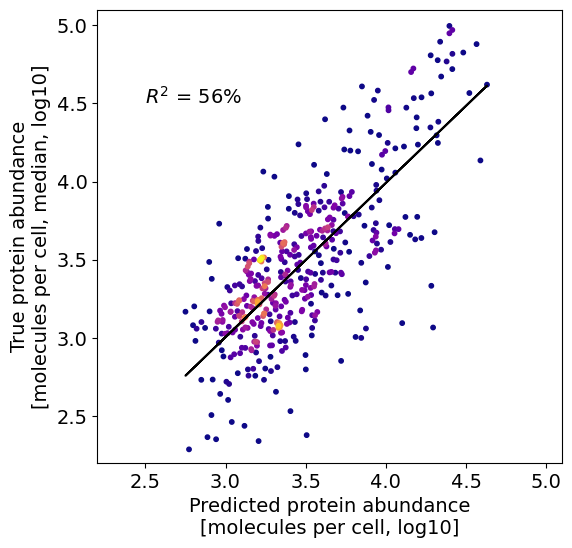

In [18]:
plt.figure(dpi=100, figsize = (6, 6))

plotting.scatter_density(
    x = the_predicted_values.ravel().astype('float32'),
    y = the_true_values.ravel().astype('float32'), 
    s = 10
)

plt.plot(the_predicted_values, regresssion.predict(the_predicted_values), color ='k')
plt.xlim(2.2, 5.1)
plt.ylim(2.2, 5.1)

plt.annotate(f'$R^2$ = {r2_score(abundances_test, predictions_test)*100:.0f}%',
             xy=(2.5, 4.5),
             fontsize=14)

plt.xlabel('Predicted protein abundance\n[molecules per cell, log10]')
plt.ylabel('True protein abundance\n[molecules per cell, median, log10]')

plt.savefig('bert_performance.pdf')

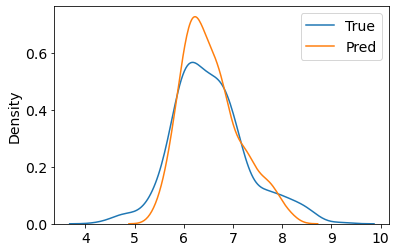

In [19]:
sns.kdeplot(abundances_test, label='True')
sns.kdeplot(predictions_test, label='Pred')
plt.legend()

## Shuffled test

In [20]:
random.seed(42)

rand_predictions_test = []
for seq in tqdm(seq_and_median_abundanes_test['seq'].values):
    rand_seq = ''.join(random.sample(seq, k=len(seq)))

    tokenized_seq = torch.tensor([tokenizer.encode(rand_seq)])
    pred, _ = model(tokenized_seq)
    rand_predictions_test.append(pred.detach().numpy()[0][0])
    
rand_predictions_test = np.array(rand_predictions_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 436/436 [08:23<00:00,  1.15s/it]


In [21]:
analysis.model_performance_table(abundances_test, rand_predictions_test)

,measure,value
0,MSE,42.987195
1,MAE,6.484105
2,MASE,11.118085
3,JSD,inf
4,Pearson,-0.062861
5,Spearman,-0.160951
6,R^2,-73.397935


In [22]:
the_predicted_shuffled_values = np.log10(special.inv_boxcox(rand_predictions_test, BOXCOX_LAMBDA)).reshape(-1, 1)

In [23]:
pd.DataFrame.from_records(
    zip(the_predicted_shuffled_values.ravel(), the_true_values.ravel()),
    columns = ['log_pred', 'log_true']
).to_csv('bert_shuffled_test_values.csv')

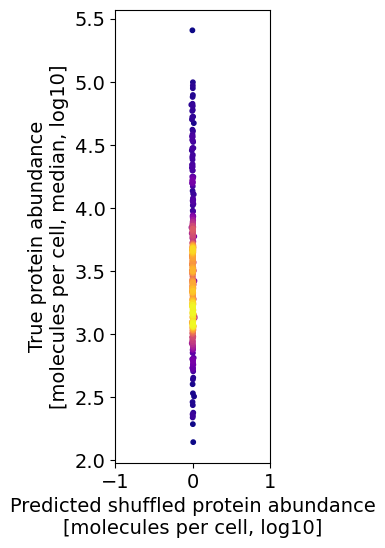

In [24]:
plt.figure(dpi=100, figsize = (2, 6))

plotting.scatter_density(
    x = the_predicted_shuffled_values.ravel().astype('float32'),
    y = the_true_values.ravel().astype('float32'), 
    s = 10
)

plt.xlim(-1, 1)

# plt.annotate(f'$R^2$ = {r2_score(abundances_test, rand_predictions_test)*100:.0f}%',
#              xy=(6, 11),
#              fontsize=14)

plt.xlabel('Predicted shuffled protein abundance\n[molecules per cell, log10]')
plt.ylabel('True protein abundance\n[molecules per cell, median, log10]')

plt.savefig('bert_shuffled_performance.pdf')